# Data prep

## This section is to prepare the data into the proper format for time series forecasting using TensorFlow

### There are many ways to architect a ML solution for TS forecasting - this one will use one of the most cutting edge methods LSTM (long/short term memory) models in a sequence to sequence architecture (seq2seq). 

Seq 2 seq is popular in many application surrounding machine translation (english to french, etc..). This makes sense as we will be taking a time series sequence of inputs to predict a time series output of predicted values

For this example, we will be using the Melbourne Daily min tempuratures dataset 
https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

to illustrate how this technique works. Note that there is only one feature and target/label here, but LSTMs take 3D shapes (n_observations, n_timesteps, n_features), and we will only be dealing with 1 element for the features



# Import and prep the data

Using TensorFlow backend.


,date,temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
5,1981-01-06,15.8
6,1981-01-07,15.8
7,1981-01-08,17.4
8,1981-01-09,21.8
9,1981-01-10,20.0


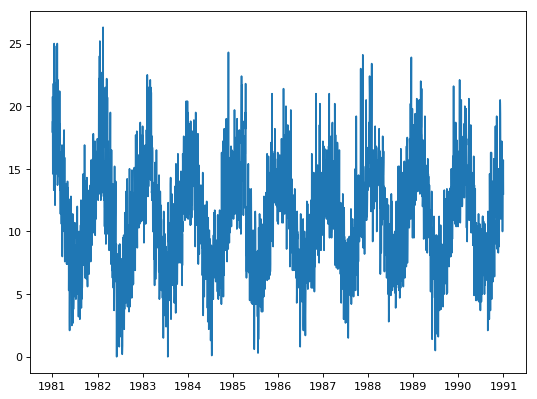

In [1]:
from matplotlib import pyplot as plt
import re
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import keras


%matplotlib inline

pandas_data = pd.read_csv('data/daily-minimum-temperatures-in-me.csv', sep=';', encoding='utf-8' )

columns = ['date', 'temp']

pandas_data.columns = columns

pandas_data['date'] = pd.to_datetime(pandas_data['date'])

pandas_data['temp'] = pandas_data['temp'].str.extract('(\d+.\d)', expand=False) #funky characters in data

pandas_data['temp'] = pandas_data['temp'].astype('float32')

pandas_data['temp'] = pandas_data['temp'].apply(lambda x: round(x,1)) #fp conversion created some noise
 
    
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt.plot(pandas_data['date'],pandas_data['temp'])


# pyplot.show
pandas_data.head(10)

In [2]:
pandas_np = pandas_data['temp'].values

dates = pandas_data['date'].values

nobs = pandas_np.shape[0]

train_obs = int(0.75 * nobs)

# we need to create a function that reshapes the data to have each observation as a time series
# and each prediction as a time series
# inspiration here: https://stackoverflow.com/questions/21229503/creating-an-numpy-matrix-with-a-lag

def lagLead4LSTM(arr, window, axis=-1):
    """
    return a running view of length 'window' over 'axis'
    the returned array has an extra last dimension, which spans the window
    """
    shape = list(arr.shape)
    shape[axis] -= (window-1)
    assert(shape[axis]>0)
    return np.lib.index_tricks.as_strided(
        arr,
        shape + [window],
        arr.strides + (arr.strides[axis],))

lag = 90
lead = 30

x1  = lagLead4LSTM(pandas_np, lag)

x = x1[:-lead,] # get rid of last observations with no lags
    

In [3]:


pandas_np.shape, x1.shape, x.shape, pandas_np[lag-1:,].shape


((3650,), (3561, 90), (3531, 90), (3561,))

In [4]:
y = lagLead4LSTM(pandas_np[lag:,],lead) 

print(x[4], y[3]) 
#last element should be same as first (tommorows data = first datapoint in y)

"the shapes for x are: {} and the shapes for y are: {}".format(x.shape, y.shape)

[15.8 15.8 15.8 17.4 21.8 20.  16.2 13.3 16.7 21.5 25.  20.7 20.6 24.8
 17.7 15.5 18.2 12.1 14.4 16.  16.5 18.7 19.4 17.2 15.5 15.1 15.4 15.3
 18.8 21.9 19.9 16.6 16.8 14.6 17.1 25.  15.  13.7 13.9 18.3 22.  22.1
 21.2 18.4 16.6 16.1 15.7 16.6 16.5 14.4 14.4 18.5 16.9 17.5 21.2 17.8
 18.6 17.  16.  13.3 14.3 11.4 16.3 16.1 11.8 12.2 14.7 11.8 11.3 10.6
 11.7 14.2 11.2 16.9 16.7  8.1  8.   8.8 13.4 10.9 13.4 11.  15.  15.7
 14.5 15.8 16.7 16.8 17.5 17.1] [17.1 18.1 16.6 10.  14.9 15.9 13.   7.6 11.5 13.5 13.  13.3 12.1 12.4
 13.2 13.8 10.6  9.  10.   9.8 11.5  8.9  7.4  9.9  9.3  9.9  7.4  8.6
 11.9 14. ]


'the shapes for x are: (3531, 90) and the shapes for y are: (3531, 30)'

# The data is now in the shape for us to to a seq2seq model
## We are using the last 30 days to predict the next 7 days

First, we need to split the data and scale it on a 0-1

In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

scaler = scaler.fit(pandas_np.reshape(-1,1))

pandas_np_scaled = scaler.transform(pandas_np.reshape(-1,1))

pandas_np_scaled

trainN = int(0.75 * pandas_np_scaled.shape[0]) # will take only the first 75 percent days

trainRaw = pandas_np_scaled[:trainN,-1]

testRaw = pandas_np_scaled[trainN+1:,-1]

trainDates = dates[:trainN]

testDates = dates[trainN+1:]

In [6]:
"The number of train cases are {} days, test cases are {} days".format(trainRaw.shape[0], testRaw.shape[0])

'The number of train cases are 2737 days, test cases are 912 days'

In [7]:
#reapply the transform above now we are split and scaled
lag = 90
lead = 30

def reshapeDataXY(rawData, lag=lag, lead=lead):
    x = lagLead4LSTM(rawData, lag)
    x = x[:-lead,]
    xs1, xs2 = x.shape
    x = x.reshape(xs1, xs2, 1) #need 1 for the one feature
    y = lagLead4LSTM(rawData[lag:,],lead) 
    ys1, ys2 = y.shape
    y = y.reshape(ys1, ys2, 1)
    return x, y


xTrain, yTrain = reshapeDataXY(trainRaw)
xTest, yTest = reshapeDataXY(testRaw)

# create padded input target sequence
decodeY = np.zeros((yTrain.shape))
decodeY[:,1:,:] = yTrain[:,:-1,:]
# print(yTrain[2])
# print(decodeY[2])

In [8]:
print(xTrain.shape, yTrain.shape, decodeY.shape)

(2618, 90, 1) (2618, 30, 1) (2618, 30, 1)


# Now to setup the LSTM seq2seq model
from: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html

Here is an example of the architecture in the context of machine translation:

![](https://blog.keras.io/img/seq2seq/seq2seq-inference.png)

An excellent explanation of GRUs and LSTMs are here

https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

![](https://cdn-images-1.medium.com/max/1600/1*VOXRGhOShoWWks6ouoDN3Q.gif)

In [17]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN, Dropout


latent_dim = 32

num_encoder_tokens = 1
num_decoder_tokens = 1

input_layers = [64, 32]
dropout = .5 #set to zero if you don't want to use dropout
output_layers = [64, 32]

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_sequences=True)(encoder_inputs)
encoder = Dropout(0.5)(encoder)
encoder_outputs, state_h, state_c = LSTM(latent_dim, return_state=True)(encoder)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs1, _, _ = decoder_lstm1(decoder_inputs, initial_state=encoder_states)
do1 = Dropout(.5)(decoder_outputs1)
decoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs2, _, _ = decoder_lstm2(do1, initial_state=encoder_states)#, intial_state=[h1,c1])
do2 = Dropout(.5)(decoder_outputs2)
decoder_dense = Dense(num_decoder_tokens, activation='linear')
decoder_output = decoder_dense(do2)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_output)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_9 (LSTM)                   (None, None, 32)     4352        input_11[0][0]                   
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, None, 32)     0           lstm_9[0][0]                     
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, None, 1)      0                                            
__________________________________________________________________________________________________
lstm_10 (L

In [92]:
# Run training

batch_size = 512
epochs = 500

#research - forced teaching (shifted by one input for decoder) does not perform well
decodeY = np.zeros(decodeY.shape)

learning_rate = 0.01
decay = 1e-7 # Learning rate decay
beta2 = .90

optimizer = keras.optimizers.Adam(lr=learning_rate, decay=decay, beta_2=beta2)

model.compile(optimizer=optimizer, loss='mean_absolute_error')
history = model.fit([xTrain, decodeY], yTrain,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=.05)

Train on 2487 samples, validate on 131 samples
Epoch 1/500
2487/2487 [==============================] - 6s 2ms/step - loss: 0.2200 - val_loss: 0.2277
Epoch 2/500
2487/2487 [==============================] - 1s 528us/step - loss: 0.2105 - val_loss: 0.1821
Epoch 3/500
2487/2487 [==============================] - 1s 532us/step - loss: 0.1940 - val_loss: 0.1746
Epoch 4/500
2487/2487 [==============================] - 1s 533us/step - loss: 0.1905 - val_loss: 0.1744
Epoch 5/500
2487/2487 [==============================] - 1s 529us/step - loss: 0.1908 - val_loss: 0.1713
Epoch 6/500
2487/2487 [==============================] - 1s 536us/step - loss: 0.1890 - val_loss: 0.1687
Epoch 7/500
2487/2487 [==============================] - 1s 540us/step - loss: 0.1881 - val_loss: 0.1683
Epoch 8/500
2487/2487 [==============================] - 1s 558us/step - loss: 0.1866 - val_loss: 0.1689
Epoch 9/500
2487/2487 [==============================] - 1s 558us/step - loss: 0.1859 - val_loss: 0.1686
Epoch 10/5

Epoch 78/500
2487/2487 [==============================] - 1s 576us/step - loss: 0.1648 - val_loss: 0.2006
Epoch 79/500
2487/2487 [==============================] - 1s 565us/step - loss: 0.1637 - val_loss: 0.1864
Epoch 80/500
2487/2487 [==============================] - 1s 572us/step - loss: 0.1633 - val_loss: 0.1946
Epoch 81/500
2487/2487 [==============================] - 1s 566us/step - loss: 0.1632 - val_loss: 0.2010
Epoch 82/500
2487/2487 [==============================] - 1s 565us/step - loss: 0.1637 - val_loss: 0.1792
Epoch 83/500
2487/2487 [==============================] - 1s 573us/step - loss: 0.1639 - val_loss: 0.2037
Epoch 84/500
2487/2487 [==============================] - 1s 567us/step - loss: 0.1621 - val_loss: 0.1865
Epoch 85/500
2487/2487 [==============================] - 1s 562us/step - loss: 0.1624 - val_loss: 0.2179
Epoch 86/500
2487/2487 [==============================] - 1s 557us/step - loss: 0.1617 - val_loss: 0.1938
Epoch 87/500
2487/2487 [======================

Epoch 155/500
2487/2487 [==============================] - 1s 547us/step - loss: 0.1490 - val_loss: 0.1646
Epoch 156/500
2487/2487 [==============================] - 1s 542us/step - loss: 0.1487 - val_loss: 0.1704
Epoch 157/500
2487/2487 [==============================] - 1s 554us/step - loss: 0.1480 - val_loss: 0.1758
Epoch 158/500
2487/2487 [==============================] - 1s 558us/step - loss: 0.1476 - val_loss: 0.1836
Epoch 159/500
2487/2487 [==============================] - 1s 552us/step - loss: 0.1481 - val_loss: 0.1798
Epoch 160/500
2487/2487 [==============================] - 1s 553us/step - loss: 0.1478 - val_loss: 0.1761
Epoch 161/500
2487/2487 [==============================] - 1s 555us/step - loss: 0.1474 - val_loss: 0.1790
Epoch 162/500
2487/2487 [==============================] - 1s 561us/step - loss: 0.1473 - val_loss: 0.1763
Epoch 163/500
2487/2487 [==============================] - 1s 556us/step - loss: 0.1470 - val_loss: 0.1759
Epoch 164/500
2487/2487 [============

2487/2487 [==============================] - 1s 548us/step - loss: 0.1395 - val_loss: 0.1956
Epoch 232/500
2487/2487 [==============================] - 1s 544us/step - loss: 0.1394 - val_loss: 0.1972
Epoch 233/500
2487/2487 [==============================] - 1s 546us/step - loss: 0.1396 - val_loss: 0.1900
Epoch 234/500
2487/2487 [==============================] - 1s 542us/step - loss: 0.1389 - val_loss: 0.1992
Epoch 235/500
2487/2487 [==============================] - 1s 544us/step - loss: 0.1394 - val_loss: 0.1928
Epoch 236/500
2487/2487 [==============================] - 1s 528us/step - loss: 0.1394 - val_loss: 0.2030
Epoch 237/500
2487/2487 [==============================] - 1s 530us/step - loss: 0.1420 - val_loss: 0.1893
Epoch 238/500
2487/2487 [==============================] - 1s 531us/step - loss: 0.1416 - val_loss: 0.1983
Epoch 239/500
2487/2487 [==============================] - 1s 548us/step - loss: 0.1417 - val_loss: 0.1974
Epoch 240/500
2487/2487 [==========================

2487/2487 [==============================] - 1s 527us/step - loss: 0.1337 - val_loss: 0.1841
Epoch 308/500
2487/2487 [==============================] - 1s 525us/step - loss: 0.1341 - val_loss: 0.1741
Epoch 309/500
2487/2487 [==============================] - 1s 527us/step - loss: 0.1336 - val_loss: 0.1772
Epoch 310/500
2487/2487 [==============================] - 1s 537us/step - loss: 0.1337 - val_loss: 0.1780
Epoch 311/500
2487/2487 [==============================] - 1s 544us/step - loss: 0.1333 - val_loss: 0.1867
Epoch 312/500
2487/2487 [==============================] - 1s 545us/step - loss: 0.1342 - val_loss: 0.1781
Epoch 313/500
2487/2487 [==============================] - 1s 540us/step - loss: 0.1337 - val_loss: 0.1733
Epoch 314/500
2487/2487 [==============================] - 1s 533us/step - loss: 0.1335 - val_loss: 0.1914
Epoch 315/500
2487/2487 [==============================] - 1s 534us/step - loss: 0.1332 - val_loss: 0.1812
Epoch 316/500
2487/2487 [==========================

2487/2487 [==============================] - 1s 528us/step - loss: 0.1303 - val_loss: 0.1852
Epoch 384/500
2487/2487 [==============================] - 1s 529us/step - loss: 0.1303 - val_loss: 0.1849
Epoch 385/500
2487/2487 [==============================] - 1s 543us/step - loss: 0.1292 - val_loss: 0.1752
Epoch 386/500
2487/2487 [==============================] - 1s 549us/step - loss: 0.1292 - val_loss: 0.1809
Epoch 387/500
2487/2487 [==============================] - 1s 541us/step - loss: 0.1292 - val_loss: 0.1851
Epoch 388/500
2487/2487 [==============================] - 1s 530us/step - loss: 0.1291 - val_loss: 0.1805
Epoch 389/500
2487/2487 [==============================] - 1s 534us/step - loss: 0.1308 - val_loss: 0.1859
Epoch 390/500
2487/2487 [==============================] - 1s 530us/step - loss: 0.1307 - val_loss: 0.1903
Epoch 391/500
2487/2487 [==============================] - 1s 529us/step - loss: 0.1300 - val_loss: 0.1860
Epoch 392/500
2487/2487 [==========================

2487/2487 [==============================] - 1s 556us/step - loss: 0.1318 - val_loss: 0.1796
Epoch 460/500
2487/2487 [==============================] - 1s 549us/step - loss: 0.1307 - val_loss: 0.1833
Epoch 461/500
2487/2487 [==============================] - 1s 540us/step - loss: 0.1305 - val_loss: 0.1707
Epoch 462/500
2487/2487 [==============================] - 1s 545us/step - loss: 0.1298 - val_loss: 0.1730
Epoch 463/500
2487/2487 [==============================] - 1s 544us/step - loss: 0.1290 - val_loss: 0.1764
Epoch 464/500
2487/2487 [==============================] - 1s 550us/step - loss: 0.1280 - val_loss: 0.1764
Epoch 465/500
2487/2487 [==============================] - 1s 537us/step - loss: 0.1284 - val_loss: 0.1682
Epoch 466/500
2487/2487 [==============================] - 1s 526us/step - loss: 0.1272 - val_loss: 0.1785
Epoch 467/500
2487/2487 [==============================] - 1s 527us/step - loss: 0.1271 - val_loss: 0.1726
Epoch 468/500
2487/2487 [==========================

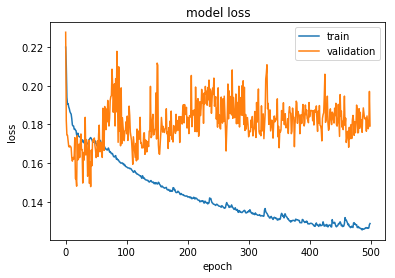

In [93]:
# summarize history for accuracy
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper right')
plt.show()

# Inference setup 


In [94]:
encoder_model = Model(encoder_inputs, encoder_states)


decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs1, _, _ = decoder_lstm1(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_outputs2, output_h, ouput_c = decoder_lstm2(decoder_outputs1, initial_state=decoder_states_inputs)

decoder_states = [output_h, ouput_c]
decoder_outputs3 = decoder_dense(decoder_outputs2)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs3] + decoder_states)

In [95]:
def decode_sequence(x, length_forecast=7, pred_batch_size=1):
    # Encode the input as state vectors.
    y_pred = []
    
    
    decoder_input = np.zeros((x.shape[0], 1, 1))
    
    states = encoder_model.predict(x)
    
    for i in range(length_forecast):

        outputs_and_states = decoder_model.predict(
                [decoder_input] + states, batch_size=pred_batch_size)
        output = outputs_and_states[0]
        states = outputs_and_states[1:]
        y_pred.append(output)
        decoder_input = output
        #decoder_input[:,i,:] = output[0][i][0]
         # Update states
        #states = [h, c]


    return np.concatenate(y_pred, axis=1)

Actual, Predicted Values:
50.9 , 49.377506
43.16 , 49.28389
41.18 , 49.175175
49.1 , 49.086784
53.06 , 49.110832
48.56 , 49.27246
45.14 , 49.568764
49.46 , 49.953835
48.92 , 50.35993
50.0 , 50.724174
51.620000000000005 , 50.994026
51.8 , 51.115913
51.620000000000005 , 51.031696
46.4 , 50.701385
52.16 , 50.150036
45.5 , 49.505566
44.96 , 48.968353
55.76 , 48.70955
55.22 , 48.802444
48.92 , 49.264027
50.36 , 50.164883
49.1 , 51.720158
54.32 , 54.119347
50.36 , 56.462337
56.120000000000005 , 56.526672
52.879999999999995 , 53.95619
46.4 , 51.206097
48.2 , 50.129654
48.74 , 50.496483
56.3 , 51.368446


/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


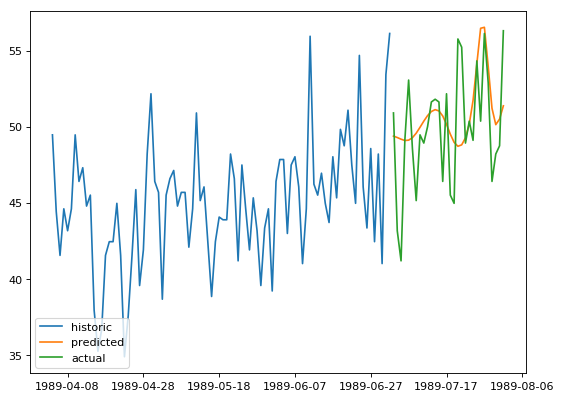

Actual, Predicted Values:
46.4 , 50.41248
46.58 , 50.49061
50.0 , 50.100426
47.3 , 49.766018
54.5 , 49.52846
59.0 , 49.515957
55.94 , 49.677315
51.8 , 49.9562
53.42 , 50.34336
46.94 , 50.84833
49.46 , 51.445965
52.34 , 52.022964
54.5 , 52.36967
48.92 , 52.308723
52.52 , 51.910786
55.76 , 51.505947
56.84 , 51.39409
60.8 , 51.620056
51.620000000000005 , 52.06158
53.42 , 52.58199
54.32 , 53.040016
55.76 , 53.26145
59.89999999999999 , 53.12293
70.88 , 52.692364
58.82 , 52.223434
57.92 , 51.962234
55.22 , 51.9801
55.58 , 52.190853
57.2 , 52.451973
64.22 , 52.612537


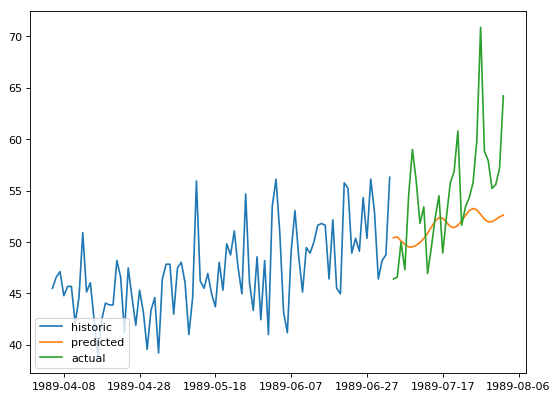

Actual, Predicted Values:
63.86 , 54.37967
61.34 , 55.11618
64.94 , 54.925545
56.660000000000004 , 55.030407
55.94 , 54.845387
51.08 , 54.38242
57.379999999999995 , 53.534714
60.8 , 52.64165
61.7 , 52.09076
57.379999999999995 , 52.042606
65.66 , 52.396645
61.16 , 52.94815
58.64 , 53.390366
54.68 , 53.340366
50.72 , 52.65321
53.96 , 51.571507
54.68 , 50.501083
53.78 , 49.785507
63.14 , 49.55069
61.519999999999996 , 49.702953
54.68 , 50.03119
54.14 , 50.28334
53.24 , 50.21337
53.6 , 49.728622
54.86 , 49.044716
61.519999999999996 , 48.557354
60.8 , 48.52696
55.94 , 48.938667
53.06 , 49.662872
50.72 , 50.62995


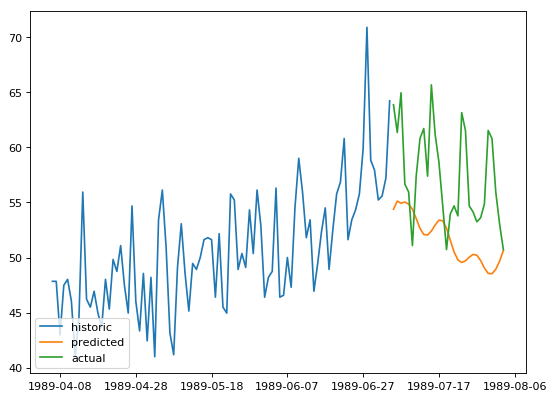

Actual, Predicted Values:
57.92 , 56.413834
54.86 , 56.196854
58.64 , 56.25203
55.94 , 56.006447
60.08 , 55.537594
58.099999999999994 , 54.79732
57.74 , 54.178062
59.540000000000006 , 53.84291
61.519999999999996 , 53.7703
58.64 , 53.838318
63.32 , 53.90696
65.84 , 53.85582
71.78 , 53.616592
66.2 , 53.222916
59.89999999999999 , 52.811367
60.440000000000005 , 52.54184
58.46 , 52.49648
51.26 , 52.634518
52.7 , 52.805523
59.0 , 52.798668
58.099999999999994 , 52.452637
58.099999999999994 , 51.782673
55.94 , 50.988415
57.74 , 50.32463
57.74 , 49.95585
68.9 , 49.90615
59.0 , 50.099976
62.78 , 50.39789
62.42 , 50.583435
62.42 , 50.397827


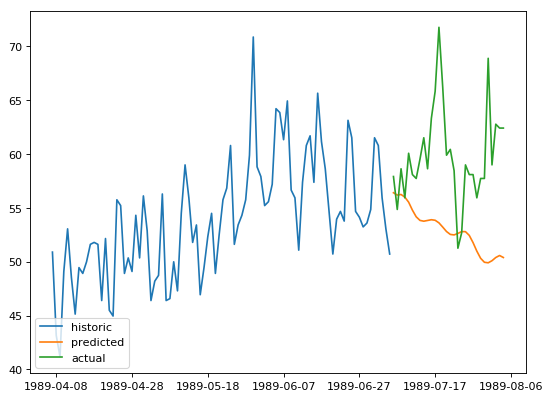

Actual, Predicted Values:
56.48 , 63.22152
61.519999999999996 , 63.516792
60.980000000000004 , 63.351868
53.6 , 62.7707
53.96 , 61.27674
58.64 , 59.38203
58.64 , 57.240997
57.92 , 55.202698
55.22 , 53.8258
56.120000000000005 , 54.190372
60.62 , 55.089428
60.980000000000004 , 55.215733
63.68 , 54.55477
60.08 , 53.283463
59.0 , 52.006516
55.4 , 51.4873
57.379999999999995 , 51.88742
63.14 , 52.867123
60.260000000000005 , 54.01284
65.48 , 54.64962
54.86 , 54.231754
57.2 , 53.054092
56.660000000000004 , 51.761726
61.34 , 50.888203
68.0 , 50.751034
62.6 , 51.252617
59.36 , 52.03486
61.7 , 52.52298
61.7 , 52.146713
63.14 , 50.905785


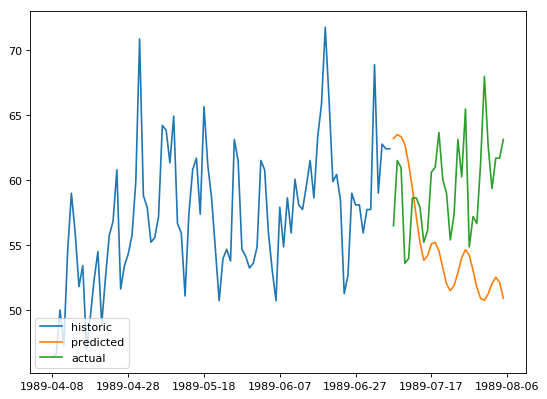

Actual, Predicted Values:
66.38 , 55.215237
66.74000000000001 , 54.09263
63.14 , 53.509483
66.2 , 53.709824
67.64 , 54.120327
66.74000000000001 , 54.863037
62.959999999999994 , 55.60885
57.56 , 55.99877
50.54 , 55.709053
55.4 , 54.684986
59.540000000000006 , 53.291584
59.0 , 52.275085
53.78 , 52.16986
48.56 , 52.79056
51.8 , 53.720127
59.0 , 54.576744
52.879999999999995 , 54.831776
52.879999999999995 , 54.204643
59.18 , 53.005524
59.0 , 51.868004
56.48 , 51.3466
54.5 , 51.568172
57.74 , 52.273865
60.8 , 53.062664
63.32 , 53.39837
62.42 , 52.871452
64.4 , 51.665
69.08 , 50.393772
57.56 , 49.627052
51.620000000000005 , 49.55424


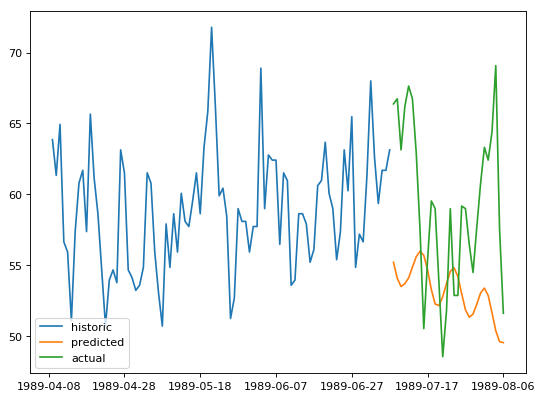

Actual, Predicted Values:
53.42 , 56.42467
55.94 , 56.02439
59.540000000000006 , 56.4246
58.46 , 56.29701
51.8 , 56.40171
53.96 , 56.267197
57.56 , 55.645313
62.6 , 54.491253
60.440000000000005 , 53.319588
59.36 , 52.68884
59.18 , 52.72564
58.46 , 53.203205
65.3 , 53.86348
61.519999999999996 , 54.4447
65.12 , 54.57129
59.18 , 54.025303
49.82 , 53.009304
50.36 , 52.01511
54.68 , 51.52984
55.76 , 51.76503
52.7 , 52.607773
56.84 , 53.684856
58.099999999999994 , 54.249382
58.46 , 53.757946
52.16 , 52.555843
54.86 , 51.19579
56.660000000000004 , 50.125366
52.7 , 49.70098
50.72 , 49.968002
48.02 , 50.647926


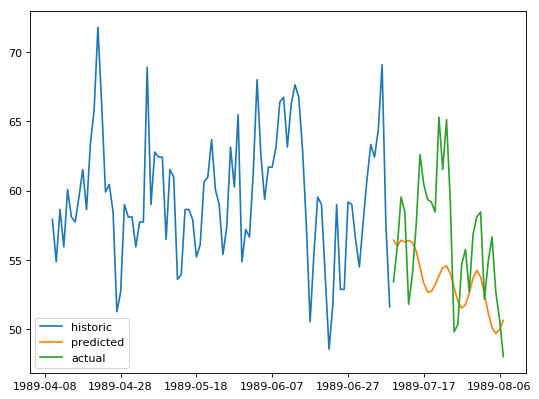

Actual, Predicted Values:
51.98 , 57.26862
49.1 , 57.54091
55.4 , 57.90535
57.02 , 57.50115
54.68 , 56.403267
57.74 , 54.10846
60.8 , 51.64965
55.94 , 50.884285
44.6 , 51.80485
40.82 , 53.274952
44.42 , 54.7297
56.660000000000004 , 55.577835
51.08 , 55.128643
54.14 , 53.53701
51.98 , 51.80257
50.36 , 50.98327
49.1 , 51.243828
48.02 , 52.034187
56.120000000000005 , 52.866646
48.379999999999995 , 53.418236
48.92 , 53.32666
47.66 , 52.502434
42.44 , 51.416904
40.1 , 50.719547
44.96 , 50.66558
50.0 , 51.08104
50.9 , 51.71233
51.26 , 52.363655
46.76 , 52.733627
42.980000000000004 , 52.452232


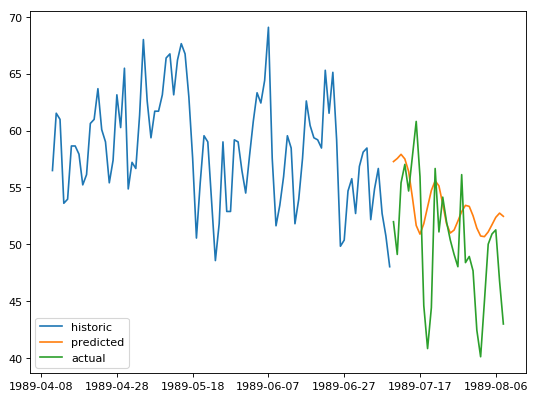

Actual, Predicted Values:
40.1 , 48.57202
42.980000000000004 , 46.683746
49.64 , 45.471386
49.46 , 45.821022
46.76 , 47.326477
47.120000000000005 , 49.53002
47.3 , 52.699665
50.72 , 58.895897
44.239999999999995 , 61.289246
42.8 , 55.57812
43.879999999999995 , 52.333538
46.04 , 50.37645
50.54 , 48.596302
44.96 , 48.091602
45.32 , 48.31024
52.52 , 48.69709
41.72 , 49.07148
39.92 , 49.55298
43.519999999999996 , 50.07792
48.74 , 50.24198
45.86 , 49.575943
46.58 , 48.740604
46.94 , 48.442497
48.379999999999995 , 48.61536
45.86 , 48.952126
51.08 , 49.273056
46.76 , 49.548428
46.22 , 49.79545
41.36 , 50.026318
42.620000000000005 , 50.243023


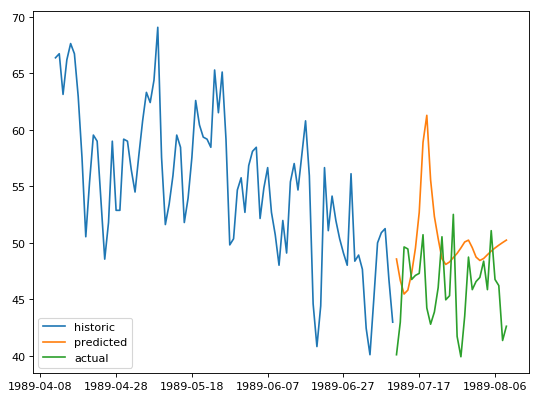

Actual, Predicted Values:
38.66 , 40.561966
42.08 , 41.05366
48.92 , 42.964546
45.32 , 44.78692
45.14 , 46.142838
45.86 , 46.62364
45.86 , 46.48845
48.74 , 46.19051
39.92 , 45.97432
42.26 , 45.88228
50.36 , 45.881752
50.36 , 45.934246
48.74 , 46.010094
41.72 , 46.09316
41.0 , 46.177074
45.68 , 46.257576
49.28 , 46.325706
50.72 , 46.367905
52.16 , 46.37233
48.379999999999995 , 46.334393
52.16 , 46.258
44.239999999999995 , 46.15229
46.94 , 46.02987
49.46 , 45.906593
49.28 , 45.79615
49.64 , 45.706837
51.44 , 45.641216
48.56 , 45.597473
43.7 , 45.57046
46.58 , 45.55424


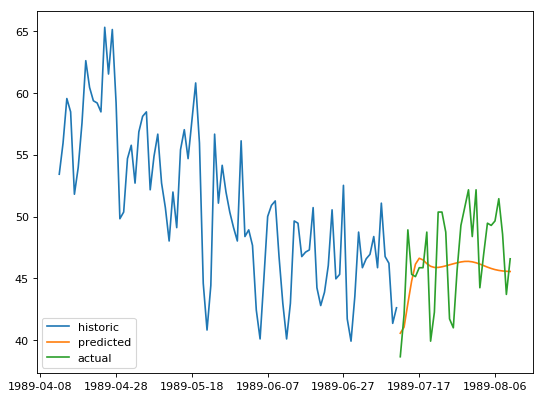

In [96]:
#print random plots for every 1000 steps
import matplotlib.dates as mdates

step = 30
offset = 365
prediction_time = 30


date_idx1 = trainN + 1 + offset - lag

date_idx2 = date_idx1 + lag + prediction_time


for i in range(10):
    
    dates = pandas_data['date'][date_idx1+i: date_idx2+i]
    dates1 = pd.to_datetime(dates, unit='s')
    dates1 = [mdates.date2num(d) for d in dates1]

    figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

    test_line = i * step + offset

    xLine = xTest[test_line,:]
    yLine = yTest[test_line,:]

    xLine = xLine.reshape(1, lag, 1)
    yHat = decode_sequence(xLine, prediction_time)
    hist = np.vstack((xLine.reshape(lag, 1), -1*np.ones(yLine.shape)))
    hist = scaler.inverse_transform(hist)*9/5 + 32
    hist[hist == 32] = np.nan

    plt.plot(dates1, hist)
    preds = np.vstack((-1*np.ones((lag, 1)), yHat[0,:]))
    preds = scaler.inverse_transform(preds)*9/5 + 32
    preds[preds == 32] = np.nan

    plt.plot(dates1, preds)
    acts = np.vstack((-1*np.ones((lag, 1)),yLine))
    acts = scaler.inverse_transform(acts)*9/5 + 32
    acts[acts == 32] = np.nan

    plt.plot(dates1, acts)
    plt.legend(['historic', 'predicted', 'actual'], loc='lower left')
    ax = plt.axes()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    print("Actual, Predicted Values:")
    for i, j in zip(yLine.flatten(), yHat.flatten()):
        i = scaler.inverse_transform(i)*9/5 + 32
        j = scaler.inverse_transform(j)*9/5 + 32
        i = i.flatten()[0]
        j = j.flatten()[0]
        print(i,",", j)
    plt.show()


In [97]:
encoder_model.save('models/DEEP_LSTMencoder.h5')
decoder_model.save('models/DEEP_LSTMdecoder.h5')

/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_11 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_29:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'input_30:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/Users/jwortz/anaconda3/envs/ThreeSix/lib/python3.6/site-packages/keras/engine/network.py:872: UserWarning: Layer lstm_12 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'input_29:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'input_30:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
